# Dataset Stuff

In [2]:
# get all image paths and count
from glob import glob
import os

file_paths = glob('./images/*/*')
n_files = len(file_paths)
print(f'Total images: {n_files}')

# check through each image
from PIL import Image
faulty_images = []
for path in file_paths:
    try:
        img = Image.open(path)
        # size check
        if img.size[0] < 1 or img.size[1] < 1:
            print(path, f'invalid size {img.size}')
            faulty_images.append(path)
    except Exception as e:
        # error reading image
        print(path, e)
        faulty_images.append(path)

if len(faulty_images) == 0:
    print('All images ok!')
else:
    print(f'Broken images found, deleting {len(faulty_images)} faulty images...')
    for path in faulty_images:
        os.remove(path)
    print('Relisting images...')
    file_paths = glob('./images/*/*')
    n_files = len(file_paths)
    print(f'Total images: {n_files}')

Total images: 22973
All images ok!


## Datasource

In [1]:
import tensorflow as tf
# '/media/zx02/HDD/DATA/anime_faces/images'

def get_dataset(image_size, batch_size):
    ds = tf.keras.preprocessing.image_dataset_from_directory('./images', label_mode=None,
                                                             shuffle=True,
                                                             batch_size=batch_size,
                                                             image_size=image_size)
    return ds.map(lambda images: (images-127.5) / 127.5).prefetch(30)

# GAN

In [2]:
from tensorflow.keras.layers import *
from tensorflow.python.keras.layers.ops import core as core_ops
import numpy as np

class PixelNormalization(Layer):
    
    def call(self, inputs):
        return inputs * tf.math.rsqrt(tf.reduce_mean(tf.square(inputs), axis=-1, keepdims=True) + 1e-8)
    
class Conv2DEqualized(Layer):
    
    kernel_initializer = tf.keras.initializers.RandomNormal(mean=0, stddev=1)
    bias_initializer = tf.keras.initializers.Zeros()
    
    def __init__(self, n_kernels, kernel_size, padding, name):
        super(Conv2DEqualized, self).__init__(name=name)
        self.n_kernels = n_kernels
        self.kernel_size = kernel_size
        self.padding = padding

    def build(self, input_shape):
        self.c = np.sqrt(2.0 / float(input_shape[-1] * self.kernel_size[0] * self.kernel_size[1]))
        with tf.name_scope(self.name):
            self.kernels = self.add_weight(
                name='kernel',
                shape=(*self.kernel_size, input_shape[-1], self.n_kernels),
                initializer=Conv2DEqualized.kernel_initializer,
                trainable=True)
            self.bias = self.add_weight(
              name='bias',
              shape=(self.n_kernels,),
              initializer=Conv2DEqualized.bias_initializer,
              trainable=True)
        
    def call(self, inputs):
        with tf.name_scope(self.name):
            x = tf.nn.conv2d(inputs, self.kernels * self.c, 1, self.padding.upper(), name='conv_op')
            x = tf.nn.bias_add(x, self.bias, name='bias_op')
            return x
        
    def get_config(self):
        return {
            'n_kernels' : self.n_kernels,
            'kernel_size' : self.kernel_size,
            'padding' : self.padding,
            'name' : self.name
        }

class DenseEqualized(Layer):

    kernel_initializer = tf.keras.initializers.RandomNormal(mean=0, stddev=1)
    bias_initializer = tf.keras.initializers.Zeros()
    
    def __init__(self, n_units, name):
        super(DenseEqualized, self).__init__(name=name)
        self.n_units = n_units

    def build(self, input_shape):
        self.c = np.sqrt(2.0 / float(input_shape[-1]))
        with tf.name_scope(self.name):
            self.kernels = self.add_weight(
                name='weight',
                shape=(input_shape[-1], self.n_units),
                initializer=DenseEqualized.kernel_initializer,
                trainable=True)
            self.bias = self.add_weight(
                name='bias',
                shape=(self.n_units,),
                initializer=DenseEqualized.bias_initializer,
                trainable=True
            )
        
    def call(self, inputs):
        with tf.name_scope(self.name):
            return core_ops.dense(inputs, self.kernels * self.c, self.bias)
        
    def get_config(self):
        return {
            'n_units' : self.n_units,
            'name' : self.name
        }
    
class FadeinMerge(Layer):
    
    def __init__(self, name):
        super(FadeinMerge, self).__init__(name=name)
        
    def build(self, input_shapes):
        self.alpha = self.add_weight(name='alpha',
                                     shape=tuple(),
                                     initializer='zero',
                                     trainable=False)
        
    def call(self, inputs):
        return (1 - self.alpha) * inputs[0] + self.alpha * inputs[1]
    
    def get_config(self):
        return {
            'name' : self.name
        }
    
class MiniBatchStdDev(Layer):

    def __init__(self, name):
        super(MiniBatchStdDev, self).__init__(name=name)
        self.group_size = 1

    def call(self, inputs):
        x = tf.transpose(inputs, perm=[0, 3, 1, 2])
        s = x.shape                                             # [NCHW]  Input shape.
        y = tf.reshape(x, [self.group_size, -1, s[1], s[2], s[3]])   # [GMCHW] Split minibatch into M groups of size G.
        y = tf.cast(y, tf.float32)                              # [GMCHW] Cast to FP32.
        y -= tf.reduce_mean(y, axis=0, keepdims=True)           # [GMCHW] Subtract mean over group.
        y = tf.reduce_mean(tf.square(y), axis=0)                # [MCHW]  Calc variance over group.
        y = tf.sqrt(y + 1e-8)                                   # [MCHW]  Calc stddev over group.
        y = tf.reduce_mean(y, axis=[1,2,3], keepdims=True)      # [M111]  Take average over fmaps and pixels.
        y = tf.cast(y, x.dtype)                                 # [M111]  Cast back to original data type.
        y = tf.tile(y, [self.group_size, 1, s[2], s[3]])        # [N1HW]  Replicate over group and pixels.
        x = tf.concat([x, y], axis=1)                           # [NCHW]  Append as new fmap.
        x = tf.transpose(x, perm=[0, 2, 3, 1])
        return x
    
    def get_config(self):
        return {
            'name' : self.name
        }
    
custom_objects = {
    'PixelNormalization' : PixelNormalization,
    'Conv2DEqualized' : Conv2DEqualized,
    'DenseEqualized' : DenseEqualized,
    'FadeinMerge' : FadeinMerge,
    'MiniBatchStdDev' : MiniBatchStdDev,
}

In [3]:
import os

class Generator:
    
    fadein_alpha = None
    model_no_fadein = None

    def __init__(self, config={}):
        # training params
        self.config = config.copy()
        self.initial_build()
            
    def initial_build(self):
        if self.config['during_fadein']:
            self.config['stage'] -= 1
        n_stage = self.config['stage']
        # normalize inputs
        self.input = Input((512), name='gen/input')
        x = PixelNormalization(name='gen/input_norm')(self.input)
        x = DenseEqualized(512 * 4 * 4, name='gen/input_map')(x)
        x = LeakyReLU(0.2, name='gen/input_map_act')(x)
        x = PixelNormalization(name='gen/input_map_norm')(x)
        x = Reshape((4, 4, 512))(x)
        for stage in range(1, n_stage+1):
            with tf.name_scope(f'stage_{stage}'):
                if stage > 1:
                    x = self.upscale_block(x, stage)
                else:
                    x = self.first_upscale_block(x)
        x = self.to_rgb(x, is_identity=False)
        self.model = Model(self.input, x)
        if self.config['during_fadein']:
            self.grow_with_fadein()
        
    def grow_with_fadein(self):
        self.config['stage'] += 1
        # skip 'to_rgb' layer to get the last Conv2D
        old_model_bottom = self.model.layers[-2]
        # build both residual & normal branches
        with tf.name_scope(f'stage_{self.config["stage"]}'):
            x_merged, x = self.upscale_block(old_model_bottom.output, self.config['stage'], use_fadein=True)
        # build model without fadein
        self.model_no_fadein = Model(self.input, x)
        # rebuild model with fadein
        self.model = Model(self.input, x_merged)
        self.find_fadein_alpha()
    
    def remove_fadein(self):
        del self.model
        self.model = self.model_no_fadein
    
    def first_upscale_block(self, x):
        prefix = 'gen/stage1/'
        x = Conv2DEqualized(512, (4, 4), padding='same', name=prefix+'conv1')(x)
        x = LeakyReLU(0.2, name=prefix+'lr1')(x)
        x = PixelNormalization(name=prefix+'pn1')(x)
        x = Conv2DEqualized(512, (3, 3), padding='same', name=prefix+'conv2')(x)
        x = LeakyReLU(0.2, name=prefix+'lr2')(x)
        x = PixelNormalization(name=prefix+'pn2')(x)
        return x
    
    def upscale_block(self, x, stage, use_fadein=False):
        if stage > 4:
            depth = int(512 / (2 ** (stage - 4)))
        else:
            depth = 512
        prefix = f'gen/stage{stage}/'
        x = UpSampling2D((2, 2), name=prefix+'us1')(x)
        if use_fadein:
            id_x = self.to_rgb(x, is_identity=True)
        x = Conv2DEqualized(depth, (3, 3), padding='same', name=prefix+'conv1')(x)
        x = LeakyReLU(0.2, name=prefix+'lr1')(x)
        x = PixelNormalization(name=prefix+'pn1')(x)
        x = Conv2DEqualized(depth, (3, 3), padding='same', name=prefix+'conv2')(x)
        x = LeakyReLU(0.2, name=prefix+'lr2')(x)
        x = PixelNormalization(name=prefix+'pn2')(x)
        # additional steps if this block is being faded in
        if use_fadein:
            # to_rgb before addition
            x = self.to_rgb(x, is_identity=False)
            # add and return both the merged and original branches
            merged_x = FadeinMerge(name='gen/fadein_merge')([id_x, x])
            return merged_x, x
        # return normally
        return x
    
    def to_rgb(self, x, is_identity=False):
        x = Conv2DEqualized(3, (1, 1), padding='same', name=f'gen/{"id_" if is_identity else ""}to_rgb')(x)
        return x
    
    def set_fadein_alpha(self, alpha):
        self.fadein_alpha.assign(alpha)
        
    def find_fadein_alpha(self):
        layer = self.model.get_layer('gen/fadein_merge')
        if layer:
            self.fadein_alpha = layer.weights[0]

In [4]:
def reflow_layers(x_in, layers):
    x = x_in
    for layer in layers:
        x = layer(x)
    return x

class Discriminator:
    
    fadein_alpha = None
    model_no_fadein = None
    
    def __init__(self, config={}):
        # training params
        self.config = config.copy()
        self.initial_build()
            
    def update_input(self):
        stage = self.config['stage']
        image_dim = int(2 ** (stage + 1))
        self.input = Input((image_dim, image_dim, 3), name='dis/input')
    
    def initial_build(self):
        if self.config['during_fadein']:
            self.config['stage'] -= 1
        n_stage = self.config['stage']
        self.update_input()
        x = self.from_rgb(self.input, n_stage, is_identity=False)
        for stage in reversed(range(1, n_stage+1)):
            with tf.name_scope(f'stage_{stage}'):
                if stage > 1:
                    x = self.downscale_block(x, stage)
                else:
                    x = self.last_block(x)
        x = Flatten(name='dis/flatten')(x)
        x = DenseEqualized(1, name='dis/dense')(x)
        self.model = Model(self.input, x)
        if self.config['during_fadein']:
            self.grow_with_fadein()
        
    def grow_with_fadein(self):
        ''' Perform fade-in growth of the discriminator.'''
        self.config['stage'] += 1
        self.update_input()
        stage = self.config["stage"]
        # skip connection
        id_x = AveragePooling2D((2, 2), name='dis/id_ap')(self.input)
        id_x = self.from_rgb(id_x, stage, is_identity=True)
        # main branch
        x = self.from_rgb(self.input, stage, is_identity=False)
        with tf.name_scope(f'stage_{stage}'):
            x = self.downscale_block(x, stage)
        # merge with alpha
        merged_x = FadeinMerge(name='dis/fadein_merge')([id_x, x])
        # build model without fadein to be used later
        # skip: Conv2D(1x1), PixelNorm to get the first non 1x1 Conv2D
        old_model_layers = self.model.layers[2:]
        x = reflow_layers(x, old_model_layers)
        self.model_no_fadein = Model(self.input, x)
        # rebuild model with fadein
        # attach new block
        fadein_x = reflow_layers(merged_x, old_model_layers)
        self.model = Model(self.input, fadein_x)
        self.find_fadein_alpha()
    
    def remove_fadein(self):
        self.model = self.model_no_fadein
        self.model_no_fadein = None
    
    def last_block(self, x):
        prefix = 'dis/stage1/'
        x = MiniBatchStdDev(name=prefix + 'minibatch_std')(x)
        x = Conv2DEqualized(512, (3, 3), padding='same', name=prefix+'conv1')(x)
        x = LeakyReLU(0.2, name=prefix+'lr1')(x)
        x = Conv2DEqualized(512, (4, 4), padding='valid', name=prefix+'conv2')(x)
        x = LeakyReLU(0.2, name=prefix+'lr2')(x)
        return x
    
    def downscale_block(self, x, stage):
        if stage > 4:
            ini_depth = int(512 / (2 ** (stage - 4)))
            final_depth = ini_depth * 2
        else:
            ini_depth = final_depth = 512
        prefix = f'dis/stage{stage}/'
        x = Conv2DEqualized(ini_depth, (3, 3), padding='same', name=prefix+'conv1')(x)
        x = LeakyReLU(0.2, name=prefix+'lr1')(x)
        x = Conv2DEqualized(final_depth , (3, 3), padding='same', name=prefix+'conv2')(x)
        x = LeakyReLU(0.2, name=prefix+'lr2')(x)
        x = AveragePooling2D((2, 2), name=prefix+'ap')(x)
        return x
    
    def from_rgb(self, x, stage, is_identity):
        if stage > 4:
            depth = int(512 / (2 ** (stage - 4)))
            if is_identity:
                depth *= 2
        else:
            depth = 512
        x = Conv2DEqualized(depth, (1, 1), padding='same', name=f'dis/{"id_" if is_identity else ""}from_rgb')(x)
        return x
    
    def set_fadein_alpha(self, alpha):
        self.fadein_alpha.assign(alpha)
        
    def find_fadein_alpha(self):
        layer = self.model.get_layer('dis/fadein_merge')
        if layer:
            self.fadein_alpha = layer.weights[0]

# WGAN

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import sys
import json
from datetime import datetime
import os

def image_size_for_stage(stage):
    dim = int(2 ** (stage + 1))
    return (dim, dim)

class WGAN(Model):
    
    epoch = 0
    g_optimizer = Adam(1e-3, 0, 0.99)
    d_optimizer = Adam(1e-3, 0, 0.99)
    
    def __init__(
        self,
        config=None,
        checkpoint_path=None
    ):
        super(WGAN, self).__init__()
        # note that config is shared among the generator and discriminator
        loading_from_save = not config
        if config:
            self.config = config
        else:
            with open(os.path.join(checkpoint_path, 'config.json')) as f:
                self.config = json.load(f)
        self.generator = Generator(self.config)
        self.discriminator = Discriminator(self.config)
        if loading_from_save:
            # prepass to initialize all vars
            self.compile()
            images = tf.random.normal((self.batch_size, *self.image_size, 3))
            self.train_step(images)
            # restore states from checkpoint
            ckpt = self.create_checkpoint()
            ckpt.restore(tf.train.latest_checkpoint(checkpoint_path))

    def create_checkpoint(self):
        if self.during_fadein:
                checkpoint = tf.train.Checkpoint(d_optimizer=self.d_optimizer, g_optimizer=self.g_optimizer,
                                                 generator=self.generator_func, discriminator=self.discriminator_func,
                                                 generator_no_fadein=self.generator.model_no_fadein, discriminator_no_fadein=self.discriminator.model_no_fadein)
        else:
            checkpoint = tf.train.Checkpoint(d_optimizer=self.d_optimizer, g_optimizer=self.g_optimizer,
                                             generator=self.generator_func, discriminator=self.discriminator_func)
        return checkpoint
                
    def compile(self):
        super(WGAN, self).compile()
        self.fadein_alpha = None
        self.d_loss_fn = lambda real_logits, fake_logits: - tf.reduce_mean(real_logits) + tf.reduce_mean(fake_logits)
        self.g_loss_fn = lambda gen_img_logits: -tf.reduce_mean(gen_img_logits)

    def gradient_penalty(self, batch_size, real_images, fake_images):
        """ Calculates the gradient penalty.

        This loss is calculated on an interpolated image
        and added to the discriminator loss.
        """
        # Get the interpolated image
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            pred = self.discriminator_func(interpolated, training=True)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 3. Calculate the norm of the gradients.
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2.0)
        return gp

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]

        # Get the batch size
        batch_size = tf.shape(real_images)[0]

        # 1. Train the generator and get the generator loss
        # 2. Train the discriminator and get the discriminator loss
        # 3. Calculate the gradient penalty
        # 4. Multiply this gradient penalty with a constant weight factor
        # 5. Add the gradient penalty to the discriminator loss
        # 6. Return the generator and discriminator losses as a loss dictionary

        # Get the latent vector
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, 512)
        )
        with tf.GradientTape() as tape:
            # Generate fake images from the latent vector
            fake_images = self.generator_func(random_latent_vectors, training=True)
            # Get the logits for the fake images
            fake_logits = self.discriminator_func(fake_images, training=True)
            # Get the logits for the real images
            real_logits = self.discriminator_func(real_images, training=True)
            # Calculate the discriminator loss using the fake and real image logits
            d_cost = self.d_loss_fn(real_logits, fake_logits)
            # Calculate the gradient penalty
            gp = self.gradient_penalty(batch_size, real_images, fake_images)
            # Add the gradient penalty to the original discriminator loss
            d_loss = d_cost + gp * 10.0

        # Get the gradients w.r.t the discriminator loss
        d_gradient = tape.gradient(d_loss, self.discriminator_func.trainable_variables)
        # Update the weights of the discriminator using the discriminator optimizer
        self.d_optimizer.apply_gradients(
            zip(d_gradient, self.discriminator_func.trainable_variables)
        )

        # Train the generator
        # Get the latent vector
        random_latent_vectors = tf.random.normal(shape=(batch_size, 512))
        with tf.GradientTape() as tape:
            # Generate fake images using the generator
            generated_images = self.generator_func(random_latent_vectors, training=True)
            # Get the discriminator logits for fake images
            gen_img_logits = self.discriminator_func(generated_images, training=True)
            # Calculate the generator loss
            g_loss = self.g_loss_fn(gen_img_logits)

        # Get the gradients w.r.t the generator loss
        gen_gradient = tape.gradient(g_loss, self.generator_func.trainable_variables)
        # Update the weights of the generator using the generator optimizer
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator_func.trainable_variables)
        )
        
        return {"d_loss": d_loss, "g_loss": g_loss,
                'mean_real_logits': tf.reduce_mean(real_logits),
                'mean_fake_logits': tf.reduce_mean(fake_logits),
                'mean_gen_logits': tf.reduce_mean(gen_img_logits)}
    
    @property
    def generator_func(self):
        return self.generator.model
    
    @property
    def discriminator_func(self):
        return self.discriminator.model
    
    @property
    def stage(self):
        return self.config['stage']
    
    @property
    def image_size(self):
        return image_size_for_stage(self.stage)
    
    @property
    def batch_size(self):
        batch_sizes = [256, 256, 128, 64, 28, 12, 6, 3, 3]
        return batch_sizes[self.stage-1]
    
    @property
    def n_epochs(self):
        epochs = [35, 45, 60, 75, 75, 30, 30, 30]
        return epochs[self.stage]
    
    @property
    def during_fadein(self):
        return self.generator.model_no_fadein is not None and self.discriminator.model_no_fadein is not None
    
    def fit_n_epochs(self, epochs, initial_epoch=0):
        self.fit(get_dataset(self.image_size, self.batch_size), epochs=epochs, callbacks=[WGANCallback()], initial_epoch=initial_epoch)

    def initial_cycle(self, override_n_epochs=None):
        n_epochs = override_n_epochs if override_n_epochs else self.n_epochs
        self.fit_n_epochs(n_epochs)
    
    def one_growth_cycle(self, override_n_epochs=None):
        n_epochs = override_n_epochs if override_n_epochs else self.n_epochs
        # from tensorflow.keras.utils import plot_model
        # the fadein_alpha will be updated by the callback after each batch
        self.config['stage'] += 1
        print(f'New stage {self.stage}')
        # grow with fade-in
        self.generator.grow_with_fadein()
        self.discriminator.grow_with_fadein()
        self.compile()
        print('Model growth completed.')
        # stabilise
        print('Stabilising with fade-in.')
        self.fit_n_epochs(n_epochs)
        # remove fade-in
        print('Removed fade-in and re-stabilising.')
        self.generator.remove_fadein()
        self.discriminator.remove_fadein()
        self.compile()
        # stabilise
        self.fit_n_epochs(n_epochs)
        
    def set_fadein_alpha(self, alpha):
        self.generator.set_fadein_alpha(alpha)
        self.discriminator.set_fadein_alpha(alpha)
        
    def save(self, checkpoint_path:str=None):
        # make folder
        now = datetime.now()
        if not checkpoint_path:
            checkpoint_path = f'saves/save_{self.config["stage"]}_' + now.strftime(f"%d-%m-%Y_%H-%M")
        os.mkdir(checkpoint_path)
        # save config
        config = self.config.copy()
        config['epoch'] = self.epoch
        config['during_fadein'] = self.during_fadein
        # create 'saves' dir if necessary
        if checkpoint_path.startswith('saves/') and not os.path.isdir('saves'):
            os.mkdir('saves')
        with open(f'{checkpoint_path}/config.json', 'w') as f:
            json.dump(config, f)
        # save model
        ckpt = self.create_checkpoint()
        save_path = ckpt.save(os.path.join(checkpoint_path, 'ckpt'))
        print(f'Model saved at {checkpoint_path}')

In [9]:
class WGANCallback(Callback):

    def on_train_batch_begin(self, batch, logs=None):
        self.batch = batch
        # update fadein_alpha every epoch
        if self.model.during_fadein:
            progress = float(self.epoch) / self.model.n_epochs + float(batch) / float(22973 // self.model.batch_size)
            self.model.set_fadein_alpha(progress)

    def on_epoch_begin(self, epoch, logs=None):
        self.model.epoch = self.epoch = epoch

    def on_epoch_end(self, epoch, logs=None):
        generate = True
        # only generate samples sparingly on the first two stages
        if self.model.stage < 3 and epoch % 3 != 0:
            return
        # generate samples
        latent = tf.random.normal((10 * 10, 512))
        images = self.model.generator_func(latent, training=False)
        images = tf.clip_by_value((images + 1.0) / 2.0, 0.0, 1.0)
        fig, ax = plt.subplots(10, 10, figsize=(30, 30))
        for i in range(10):
            for j in range(10):
                ax[i][j].imshow(images[i * 10 + j])
        fig.tight_layout()
        # write to image
        stage = self.model.stage
        # make dir 'generated' if necessary
        if not os.path.isdir('generated'):
            os.mkdir('generated')
        file_name = f'generated/stage{stage}_epoch{epoch}.png'
        fig.savefig(file_name)
        plt.close()
        # save model every 10 epochs for stage > 4
        if stage > 4 and epoch % 10 == 0 and epoch > 0:
            self.model.save()

In [259]:
from tensorflow.keras.optimizers import Adam

gan = WGAN({ 'stage' : 1, 'during_fadein' : False })
gan.compile()
gan.initial_cycle()
gan.save()

Found 22973 files belonging to 1 classes.
Epoch 1/45
90/90 [==============================] - 15s 143ms/step - d_loss: -0.8082 - g_loss: 4.5313 - mean_real_logits: -0.1254 - mean_fake_logits: -2.3730 - mean_gen_logits: -4.5313
Epoch 2/45
90/90 [==============================] - 14s 145ms/step - d_loss: -1.0502 - g_loss: 0.1936 - mean_real_logits: 1.5494 - mean_fake_logits: 0.1263 - mean_gen_logits: -0.1936
Epoch 3/45
90/90 [==============================] - 14s 144ms/step - d_loss: -0.6266 - g_loss: -0.3914 - mean_real_logits: 1.6571 - mean_fake_logits: 0.8018 - mean_gen_logits: 0.3914
Epoch 4/45
90/90 [==============================] - 14s 143ms/step - d_loss: -0.4600 - g_loss: -0.5893 - mean_real_logits: 1.5568 - mean_fake_logits: 0.9000 - mean_gen_logits: 0.5893
Epoch 5/45
90/90 [==============================] - 14s 143ms/step - d_loss: -0.3987 - g_loss: -0.8369 - mean_real_logits: 1.7038 - mean_fake_logits: 1.1430 - mean_gen_logits: 0.8369
Epoch 6/45
90/90 [=======================

In [ ]:
# gan.one_growth_cycle()
gan.during_fadein = False
gan.save()

In [7]:
gan = WGAN(checkpoint_path='save')

In [8]:
gan.one_growth_cycle()
gan.save()

New stage 3
Model growth completed.
Stabilising with fade-in.
Found 22973 files belonging to 1 classes.
Epoch 1/60
180/180 [==============================] - 45s 225ms/step - d_loss: -3.8574 - g_loss: 2.9772 - mean_real_logits: 5.1577 - mean_fake_logits: 0.4985 - mean_gen_logits: -2.9772
Epoch 2/60
180/180 [==============================] - 40s 219ms/step - d_loss: -3.1951 - g_loss: 1.4349 - mean_real_logits: 3.9226 - mean_fake_logits: 0.2341 - mean_gen_logits: -1.4349
Epoch 3/60
180/180 [==============================] - 40s 217ms/step - d_loss: -2.8792 - g_loss: 0.0100 - mean_real_logits: 4.8079 - mean_fake_logits: 1.5316 - mean_gen_logits: -0.0100 
Epoch 4/60
180/180 [==============================] - 40s 217ms/step - d_loss: -2.3975 - g_loss: -0.0141 - mean_real_logits: 3.7275 - mean_fake_logits: 0.9987 - mean_gen_logits: 0.0141
Epoch 5/60
180/180 [==============================] - 40s 217ms/step - d_loss: -2.2968 - g_loss: 1.1168 - mean_real_logits: 3.6323 - mean_fake_logits: 0.88

In [7]:
gan = WGAN(checkpoint_path='save_3_26-02-2021_08-54')

In [8]:
gan.one_growth_cycle()
gan.save()

============] - 140s 388ms/step - d_loss: -1.6330 - g_loss: 2.8704 - mean_real_logits: -0.0865 - mean_fake_logits: -1.9256 - mean_gen_logits: -2.8704
Epoch 46/75
359/359 [==============================] - 140s 388ms/step - d_loss: -1.6519 - g_loss: 2.6099 - mean_real_logits: 0.1658 - mean_fake_logits: -1.6600 - mean_gen_logits: -2.6099
Epoch 47/75
359/359 [==============================] - 140s 388ms/step - d_loss: -1.6562 - g_loss: 3.2190 - mean_real_logits: -0.3480 - mean_fake_logits: -2.1825 - mean_gen_logits: -3.2190
Epoch 48/75
359/359 [==============================] - 140s 388ms/step - d_loss: -1.7163 - g_loss: 2.9739 - mean_real_logits: -0.0486 - mean_fake_logits: -1.9469 - mean_gen_logits: -2.9739
Epoch 49/75
359/359 [==============================] - 140s 388ms/step - d_loss: -1.7257 - g_loss: 2.6391 - mean_real_logits: 0.1894 - mean_fake_logits: -1.7245 - mean_gen_logits: -2.6391
Epoch 50/75
359/359 [==============================] - 140s 388ms/step - d_loss: -1.7490 - g_los

In [10]:
gan = WGAN(checkpoint_path='save_4_26-02-2021_14-57')
gan.fit_n_epochs(100, 75)
gan.save()

Found 22973 files belonging to 1 classes.
Epoch 76/100
359/359 [==============================] - 137s 378ms/step - d_loss: -1.3259 - g_loss: 0.2730 - mean_real_logits: 1.6149 - mean_fake_logits: 0.1988 - mean_gen_logits: -0.2730
Epoch 77/100
359/359 [==============================] - 138s 384ms/step - d_loss: -1.3074 - g_loss: 0.0539 - mean_real_logits: 1.8210 - mean_fake_logits: 0.4249 - mean_gen_logits: -0.0539
Epoch 78/100
359/359 [==============================] - 135s 374ms/step - d_loss: -1.3187 - g_loss: -0.0128 - mean_real_logits: 1.8729 - mean_fake_logits: 0.4656 - mean_gen_logits: 0.0128
Epoch 79/100
359/359 [==============================] - 135s 374ms/step - d_loss: -1.3348 - g_loss: 0.3111 - mean_real_logits: 1.5933 - mean_fake_logits: 0.1691 - mean_gen_logits: -0.3111
Epoch 80/100
359/359 [==============================] - 135s 374ms/step - d_loss: -1.3321 - g_loss: 0.2962 - mean_real_logits: 1.5707 - mean_fake_logits: 0.1490 - mean_gen_logits: -0.2962
Epoch 81/100
359/3

In [ ]:
gan.fit_n_epochs(150, 100)
gan.save()

In [ ]:
gan.one_growth_cycle()
gan.save()

In [ ]:
gan.one_growth_cycle()

Found 63569 files belonging to 1 classes.


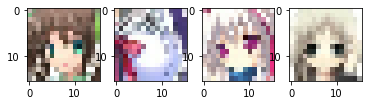

In [12]:
import matplotlib.pyplot as plt

images = []

for image in get_dataset((16, 16), 4).unbatch().take(4):
    images.append((image.numpy() + 1.0) / 2.0)
fig, ax = plt.subplots(1, 4)

for i in range(4):
    ax[i].imshow(images[i])

In [ ]:
noise = tf.random.normal((36, 512))

images = gan.generator_func(noise, training=False)
images += 1.0
images /= 2.0
images = (images - tf.reduce_min(images, axis=[1, 2], keepdims=True)) / (tf.reduce_max(images, axis=[1, 2], keepdims=True) - tf.reduce_min(images, axis=[1, 2], keepdims=True))

fig, ax = plt.subplots(6, 6, figsize=(20, 20))

for i in range(6):
    for j in range(6):
        ax[i][j].imshow(images[i * 6 + j])